# Activation statistics and weight initialization
In this [video lesson](https://www.youtube.com/watch?v=gYpoJMlgyXA&t=38m49s), Andrej Karpathy does everything in `Numpy`.  Here, we use `PyTorch`, so that we can use the `forward()` method and forward hook functions to store internal values.


We investigate the statistics of the activations in a multi-layer perceptron in relation to the distribution of the weights in the model.

Consider an MLP with zero biases,
$$h_{i+1} = f(W_{i+1}h_i)\,,\quad i=0, \dots L-1\,,$$
where $f$ is a non-linearity such as sigmoid, tanh, or relu.  
For simplicity we take all layers to have equal width $H$, i.e.
$$h_i\in\mathbb R^H\,,\qquad i=0, \dots, L\,,$$

The weights $W_i\in\mathbb R^{H\times H}$, $i=1, \dots, L$, are i.i.d. Gaussian with zero mean and standard deviation $\epsilon$.
We draw $N$ input samples $h_0$ from the unit normal distribution and compute the distribution of the activations $h_i$, $i=1,\dots, L$ to the hidden and output layers.

---
tags: pytorch, exploration, statistics, weights initialization, activations, Andrej Karpathy

# Imports

In [1]:
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [2]:
non_linearities = {'relu': nn.ReLU, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid, 'softplus': nn.Softplus}

# Parameters

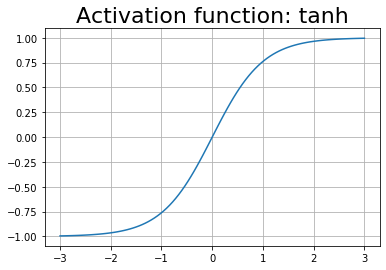

In [3]:
activ_name = 'tanh' # 'softplus' #'sigmoid' #'relu'

L = 5 # length/depth of net: number of (hidden?) layers
H = 500 # height/width of net: dimension of hidden inputs
N = 1000 # number of samples

scale = 1/np.sqrt(H) #1/np.sqrt(H) #.01 #.08 #.01


x = torch.linspace(-3., 3, 101)
with torch.no_grad():
    f = non_linearities[activ_name]()(x)


plt.plot(x, f);
plt.grid();
plt.title(f"Activation function: {activ_name}", fontsize=22);

# Model

In [4]:
linears = [nn.Linear(H, H) for _ in range(L)] 
activs = [non_linearities[activ_name]() for _ in range(L)]

model = nn.Sequential(*[item for pair in zip(linears, activs) for item in pair])

for i, module in model.named_modules():
    if isinstance(module, nn.Linear):
        module.bias.data = torch.zeros_like(module.bias.data)
        module.weight.data = scale * torch.randn(module.weight.data.shape)

hvals = []

def hook_init_hvals(module, input, output):
    global hvals
    hvals = []
    
def hook_input(module, input, output):
    hvals.append(input[0].data)

def hook_output(module, input, output):
    hvals.append(output.data)
    
def hook_stack_hvals(module, input, output):
    global hvals
    hvals = torch.stack(hvals, dim=0)

for name, module in model.named_modules():
    if name == '0' and isinstance(module, nn.Linear):
        module.register_forward_hook(hook_init_hvals)
        module.register_forward_hook(hook_input)
    if isinstance(module, non_linearities[activ_name]):
        module.register_forward_hook(hook_output)
    if name == f"{2*(L-1)+1}":
        module.register_forward_hook(hook_stack_hvals)

# Data: $h_0, \dots, h_L$

In [5]:
D = torch.randn(N, H) # -1. + 2 * torch.rand(N, H)

y = model(D)

# Means and standard deviations across layers

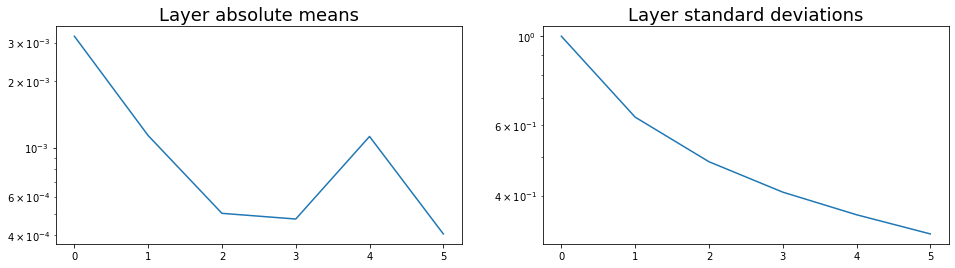

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

ax = axs[0]
ax.plot(hvals.mean(dim=[1,2]).abs());
ax.set_yscale('log')
ax.set_title("Layer absolute means", fontsize=18);

ax = axs[1]
ax.plot(hvals.std(dim=[1,2]));
ax.set_yscale('log')
ax.set_title("Layer standard deviations", fontsize=18);

# Distributions across layers

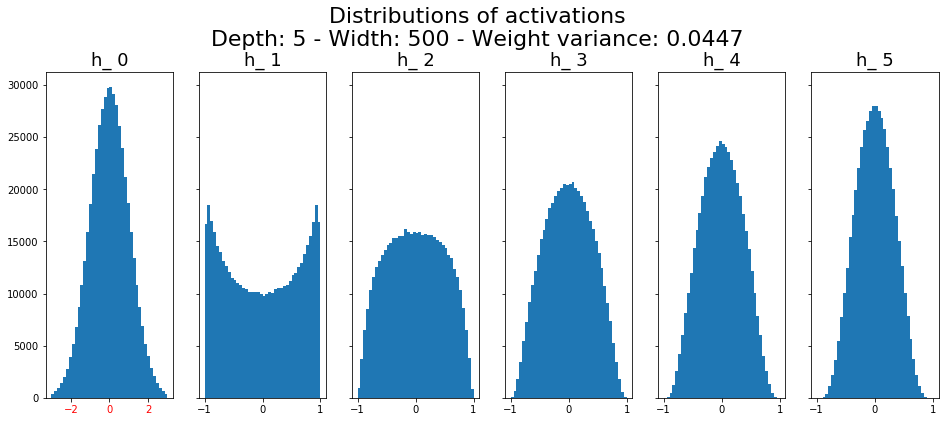

In [7]:
fig, axs = plt.subplots(1, hvals.shape[0], figsize=(16, 6), sharey=True)

for i, (ax, h) in enumerate(zip(axs, hvals)):
    bins = np.linspace(-3, 3, 41) if i == 0 else np.linspace(-1, 1, 41)
    if i == 0:
        ax.tick_params(axis='x', labelcolor='red')
    ax.hist(h.view(1,-1), bins);
    ax.set_title(f"h_{i:>2}", fontsize=18)
    
fig.suptitle(f"Distributions of activations\nDepth: {L} - Width: {H} - Weight variance: {scale:.4f}", fontsize=22, y=1.03);